In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
import os
import zipfile

drive.mount("/content/drive")
zip_dir: str = "/content/drive/MyDrive/Colab Notebooks/datasets/animals-20250626T072843Z-1-001/animals"
output_dir: str = "/content/animal_dataset"

os.makedirs(output_dir, exist_ok=True)

for zip_file in ["cat.zip", "dog.zip", "spider.zip"]:
  with zipfile.ZipFile(os.path.join(zip_dir, zip_file), 'r') as zip_ref:
    zip_ref.extractall(output_dir)

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder("/content/animal_dataset", transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# EDA

In [ ]:
from collections import Counter

base_path = "/content/animal_dataset"
class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in os.listdir(base_path)}
print(class_counts)

{'spider': 4821, 'dog': 4863, 'cat': 1668}


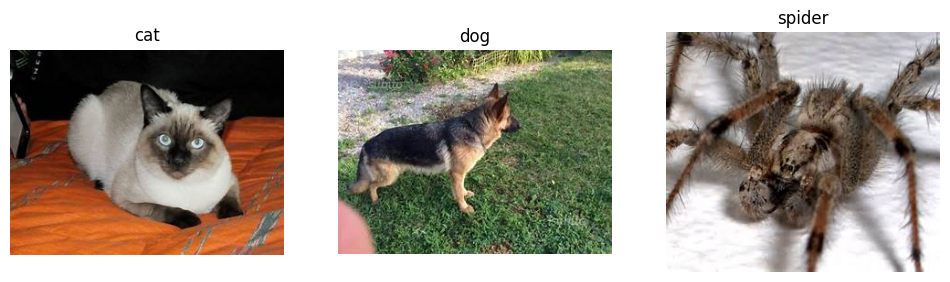

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

fig, axis = plt.subplots(1, 3, figsize=(12, 4))
classes = ["cat", "dog", "spider"]

for i, cls in enumerate(classes):
  img_path = os.path.join(base_path, cls, os.listdir(os.path.join(base_path, cls))[0])
  img = Image.open(img_path)
  axis[i].imshow(img)
  axis[i].set_title(cls)
  axis[i].axis("off")

plt.show()

In [ ]:
import numpy as np

sizes = []
for cls in classes:
  folder = os.path.join(base_path, cls)
  for fname in os.listdir(folder):
    img = Image.open(os.path.join(folder, fname))
    sizes.append(img.size)                            # (width, height)

sizes = np.array(sizes)
print("Average size: {}".format(sizes.mean(axis=0)))

Average size: [323.13601128 262.09311135]


In [ ]:
from PIL import UnidentifiedImageError

for cls in classes:
  for fname in os.listdir(os.path.join(base_path, cls)):
    try:
      img = Image.open(os.path.join(base_path, cls, fname))
      img.verify()
    except UnidentifiedImageError:
      print("Corrupt image: {} in class: {}".format(fname, cls))

Chênh lệch khá lớn giữa kích cỡ dữ liệu của nhãn mèo (1668 ảnh) so với 2 nhãn còn lại là chó (4863 ảnh) và nhện (4821 ảnh)

In [ ]:
from collections import Counter
import numpy as np

labels = [sample[1] for sample in dataset]
class_counts = Counter(labels)
print("Class counts: {}".format(class_counts))

Class counts: Counter({1: 4863, 2: 4821, 0: 1668})


In [ ]:
num_samples = len(dataset)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
print("Class weights: {}".format(class_weights))

sample_weights = [class_weights[label] for label in labels]
sample_weights = torch.DoubleTensor(sample_weights)

Class weights: {0: 6.805755395683454, 1: 2.3343615052436766, 2: 2.3546981953951462}


In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

Đưa kích cỡ ảnh của cả 3 nhãn về 128x128

In [ ]:
import shutil

src_dir = "/content/animal_dataset"
resized_dir = "/content/animal_dataset_resized"
target_size = (128, 128)

os.makedirs(resized_dir, exist_ok=True)

for class_name in os.listdir(src_dir):
  class_src_path = os.path.join(src_dir, class_name)
  class_dist_path = os.path.join(resized_dir, class_name)
  os.makedirs(class_dist_path, exist_ok=True)

  for img_name in os.listdir(class_src_path):
    img_src_path = os.path.join(class_src_path, img_name)
    img_dist_path = os.path.join(class_dist_path, img_name)

    try:
      img = Image.open(img_src_path).convert("RGB")
      img = img.resize(target_size)
      img.save(img_dist_path)
    except Exception as ex:
      print("Failed to process: {} -> {}".format(img_name, ex))

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder("/content/animal_dataset_resized", transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
resized_dir = "/content/animal_dataset_resized"
expected_size = (128, 128)
wrong_size_imgs = []

for class_name in os.listdir(resized_dir):
  class_path = os.path.join(resized_dir, class_name)
  for img_name in os.listdir(class_path):
    img_path = os.path.join(class_path, img_name)
    try:
      img = Image.open(img_path)
      if img.size != expected_size:
        wrong_size_imgs.append((img_name, img.size))
    except Exception as ex:
      print("Couldn't open: {} -> {}".format(img_name, ex))

if wrong_size_imgs:
  print("Found {} images with incorrect size".format(len(wrong_size_imgs)))
  for name, size in wrong_size_imgs[:10]:
    print("{}: {}".format(name, size))
else:
  print("All images are resized to 128x128!")

All images are resized to 128x128!


# Modeling

In [ ]:
from torch.utils.data import random_split

generator = torch.Generator().manual_seed(42)

train_size = int(0.8 * len(dataset))
test_size = int(len(dataset)) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size], generator=generator)

In [ ]:
import json
from torch.utils.data import Subset

train_indices = train_set.indices if isinstance(train_set, Subset) else train_set.indices
test_indices = test_set.indices if isinstance(test_set, Subset) else test_set.indices

with open("train_indices.json", 'w') as f:
  json.dump(train_indices, f)
with open("test_indices.json", 'w') as f:
  json.dump(test_indices, f)

In [ ]:
with open("train_indices.json", 'r') as f:
  train_indices = json.load(f)
with open("test_indices.json", 'r') as f:
  test_indices = json.load(f)

train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

In [ ]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

dataset = ImageFolder("/content/animal_dataset_resized")
class_names = dataset.classes

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [ ]:
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

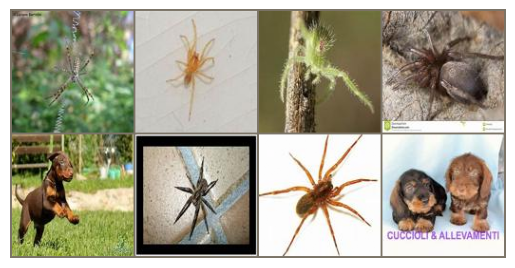

In [ ]:
import torchvision

def imshow(img):
  img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
  img = img.clamp(0, 1)
  plt.imshow(img.permute(1, 2, 0))
  plt.axis("off")

dataiter = iter(train_loader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs[:8], nrow=4))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=3):
    super(CNN, self).__init__()

    # convolutional layer
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # input channels 3(RGB), output 16
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

    # pooling layer
    self.pool = nn.MaxPool2d(2, 2)

    # fully connected layer
    self.fc1 = nn.Linear(64 * 16 * 16, 128)                   # from final feature map to 128
    self.fc2 = nn.Linear(128, num_classes)

    # dropout for regularization
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    # convolution + ReLU + Pooling
    x = self.pool(F.relu(self.conv1(x)))                      # [B, 16, 64, 64]
    x = self.pool(F.relu(self.conv2(x)))                      # [B, 32, 32, 32]
    x = self.pool(F.relu(self.conv3(x)))                      # [B, 64, 16, 16]

    # flatten
    x = x.view(-1, 64 * 16 * 16)

    # fully connected layers
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                  [-1, 128]       2,097,280
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 3]             387
Total params: 2,121,251
Trainable params: 2,121,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.38
Params size (MB): 8.09
Estimated Total Size (MB): 12.66
--------------------------------------

In [ ]:
from tqdm import tqdm

def evaluate(model, data_loader, criterion, device):
  model.eval()
  loss = 0.0
  correct = 0.0
  total = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  avg_loss = loss / len(data_loader)
  accuracy = correct / total
  return avg_loss, accuracy


def training(model, train_loader, test_loader, criterion, optimizer, epochs, device):
  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(0, epochs, 1):
    print(f"Epoch: {epoch + 1}/{epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # evaluate
    model.eval()
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # store metrics
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Train loss: {avg_train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

  return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
  epochs = range(1, len(train_losses) + 1)

  # loss plot
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="Train Loss")
  plt.plot(epochs, test_losses, label="Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()

  # accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracies, label="Train Accuracy")
  plt.plot(epochs, test_accuracies, label="Test Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy Curve")
  plt.legend()

  plt.show()

Epoch: 1/10


100%|██████████| 284/284 [00:09<00:00, 30.91it/s]


Train loss: 0.7773, Train accuracy: 0.6631
Test Loss: 0.6066, Test Acc: 0.7490
Epoch: 2/10


100%|██████████| 284/284 [00:07<00:00, 36.39it/s]


Train loss: 0.5714, Train accuracy: 0.7700
Test Loss: 0.5343, Test Acc: 0.7825
Epoch: 3/10


100%|██████████| 284/284 [00:10<00:00, 27.76it/s]


Train loss: 0.4827, Train accuracy: 0.8038
Test Loss: 0.5342, Test Acc: 0.7759
Epoch: 4/10


100%|██████████| 284/284 [00:09<00:00, 29.41it/s]


Train loss: 0.3887, Train accuracy: 0.8499
Test Loss: 0.5746, Test Acc: 0.7904
Epoch: 5/10


100%|██████████| 284/284 [00:09<00:00, 29.96it/s]


Train loss: 0.3281, Train accuracy: 0.8688
Test Loss: 0.5006, Test Acc: 0.8230
Epoch: 6/10


100%|██████████| 284/284 [00:07<00:00, 36.01it/s]


Train loss: 0.2437, Train accuracy: 0.9069
Test Loss: 0.6584, Test Acc: 0.7706
Epoch: 7/10


100%|██████████| 284/284 [00:08<00:00, 33.06it/s]


Train loss: 0.1872, Train accuracy: 0.9297
Test Loss: 0.5637, Test Acc: 0.8195
Epoch: 8/10


100%|██████████| 284/284 [00:09<00:00, 29.78it/s]


Train loss: 0.1379, Train accuracy: 0.9478
Test Loss: 0.6205, Test Acc: 0.8230
Epoch: 9/10


100%|██████████| 284/284 [00:09<00:00, 29.77it/s]


Train loss: 0.1052, Train accuracy: 0.9630
Test Loss: 0.7269, Test Acc: 0.8287
Epoch: 10/10


100%|██████████| 284/284 [00:08<00:00, 32.97it/s]


Train loss: 0.0857, Train accuracy: 0.9709
Test Loss: 0.8073, Test Acc: 0.8137


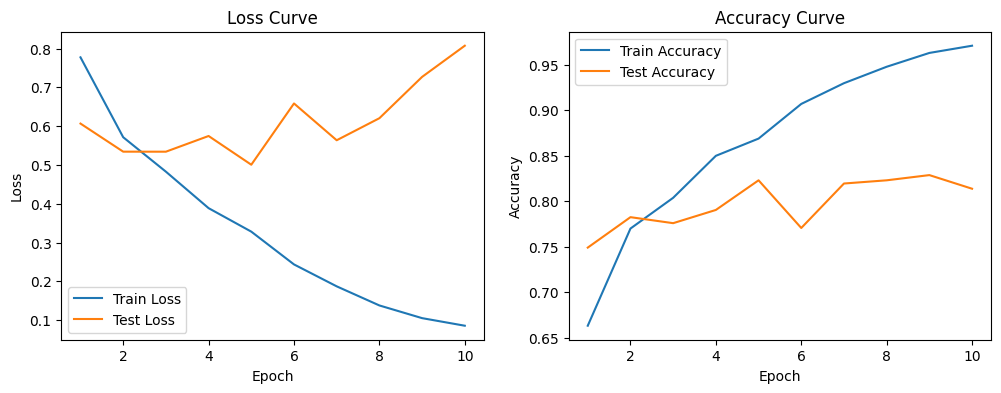

In [ ]:
EPOCHS = 10

train_losses, test_losses, train_accuracies, test_accuracies = training(
    model, train_loader, test_loader, criterion, optimizer, EPOCHS, device
)

plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
import torchvision

def show_predictions(model, test_loader, class_names, device):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 10))
    for idx in range(9):
        ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
        img = images[idx].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)  # unnormalize
        img = img.clamp(0, 1)
        plt.imshow(img.permute(1, 2, 0))
        ax.set_title(f"True: {class_names[labels[idx]]}\nPredicted: {class_names[preds[idx]]}")


In [ ]:
show_predictions(model, test_loader, class_names, device)